In [ ]:
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from imgaug import augmenters as iaa
from sklearn.ensemble import IsolationForest
import xgboost as xgb
import pandas as pd
import cv2
import warnings
import json
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

# Load the dataset from the CSV file
data = pd.read_csv("../csv/minority_train.csv")

# Initialize variables to store sampled data as lists
sampled_image_paths = []
sampled_class_labels = []

# Specify the number of samples per class and the total number of samples
samples_per_class = 20  # Adjust as needed
total_samples = 100

# Iterate through unique classes
unique_classes = data["dx"].unique()
for class_label in unique_classes:
    # Select samples for the current class
    class_data = data[data["dx"] == class_label].head(samples_per_class)
    
    # Append the sampled image paths and class labels to the result lists
    sampled_image_paths.extend(class_data["image_pth"].tolist())
    sampled_class_labels.extend(class_data["dx"].tolist())


# Initialize an empty list to store images
images = []

# Load images using OpenCV and convert to grayscale
for image_path in sampled_image_paths:
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    images.append(image)


X = np.array(images)  # Convert to numpy array

# Convert class labels to numeric values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(sampled_class_labels)

# Flatten the image data
X = X.reshape(X.shape[0], -1)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


print(f"ytest: {np.unique(y_test)}")
print(f"ytrain: {np.unique(y_train)}")

class_distribution_test = np.bincount(y_test)
class_distribution_train = np.bincount(y_train)
print("Class distribution in y_test:", class_distribution_test)
print("Class distribution in y_train:", class_distribution_train)

# Generate a synthetic multiclass classification dataset (you should replace this with your real data)
# X, y = make_classification(n_samples=1000, n_features=20, n_classes=5, n_informative=5, random_state=42)


# Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = (X_train * 255).astype(np.uint8)
X_test = (X_test * 255).astype(np.uint8)

# Define a list of augmentation techniques
augmentations = [
    iaa.Fliplr(0.5),  # Horizontal flip with 50% probability
    iaa.Flipud(0.5),  # Vertical flip with 50% probability
    # iaa.Affine(rotate=(-45, 45)),  # Rotation between -45 and 45 degrees
    iaa.Multiply((0.5, 1.5)),  # Brightness multiplication between 0.5 and 1.5
]

# Define the base classifier (Decision Tree)
base_classifier = DecisionTreeClassifier(max_depth=1)

# Initialize AdaBoostClassifier with the base classifier

adaboost_classifier = AdaBoostClassifier(base_classifier, n_estimators=50, random_state=42)

# Create a dictionary to store classification reports for each augmentation and class
augmentation_reports = {}
unique_classes_test = np.unique(y_test)


# Train AdaBoost with each augmentation technique for each class and record classification report
num_iterations = 10  # Number of iterations to test each augmentation
consolidated_x = []
consolidated_y = []
for augmentation in augmentations:
    augmentation_reports[augmentation] = {}
    print(f"Augmentation: {augmentation.name}")
    for class_label in np.unique(y_train):
        print(f"Class: {class_label}")
        class_mask = (y_train == class_label)
        other_mask = (y_train != class_label)
        
        other_labels = []
        class_labels = []
        
        for label in other_mask:
            other_labels.append(label)
        
        for label in class_mask:
            class_labels.append(label)
        
        augmented_X_train = X_train[class_mask].copy()
        non_augmented_X_train = X_train[other_mask].copy()
        
        # Apply augmentation to the samples of the current class
        augmented_X_train = augmentation.augment_images(augmented_X_train)
        
        
        # augmented should be combined with X-train left over data.
        all_data = np.concatenate((augmented_X_train, non_augmented_X_train), axis=0)
        all_labels = np.concatenate((y_train[class_mask], y_train[other_mask]), axis=0)
        
        # Fit AdaBoost classifier for the current class
        # adaboost_classifier.fit(augmented_X_train, y_train[class_mask])
        adaboost_classifier.fit(all_data, all_labels)
        
        
        # Evaluate the classifier on the test set
        y_pred = adaboost_classifier.predict(X_test)
        # Check unique classes in y_test and y_pred
        print(f'Unique classes test : {np.unique(y_test)}')
        print(f'Unique classes pred : {np.unique(y_pred)}')
        
        # # Confirm that both sets of unique classes match
        # if np.array_equal(unique_classes_test, unique_classes_pred):
        #     target_names = [f'Class_{i}' for i in unique_classes_test]
        # else:
        #     print("Mismatch in unique classes between y_test and y_pred.")
        
        # Then, when calling classification_report, pass the target_names parameter
        classification_rep = classification_report(y_test, y_pred, target_names=unique_classes_test, output_dict=True)
        # Store the classification report in the dictionary with keys based on augmentation and class
        augmentation_reports[augmentation][f'Class_{class_label}'] = classification_rep

# Print the classification report for each augmentation technique and class
for augmentation, class_reports in augmentation_reports.items():
    print("#" * 40)
    print(f"\nAugmentation:  == {augmentation.name} ==\n")
    print("=" * 40)
    for class_label, report in class_reports.items():
        print(f"Class {class_label} Classification Report:")
        for metric, value in report.items():
            if metric != 'accuracy' and f"Class_{metric}" == class_label:
                print(f"metric: Class_{metric}, class_label: {class_label}")
                print(f"{metric}: {value:.2f}" if isinstance(value, (float, np.float32)) else f"{metric}: {value}")
        print("=" * 40)
    print("#" * 40)


with open('./augment/metrics.txt', 'w+')as metrics:
    json.dump(augmentation_reports, metrics)
# print("*" * 40)
# print(class_reports)
# print("*" * 40)



ytest: [0 1 2 3 4 5]
ytrain: [0 1 2 3 4 5]
Class distribution in y_test: [3 5 3 3 5 5]
Class distribution in y_train: [17 15 17 17 15 15]
Augmentation: UnnamedFliplr
Class: 0
Unique classes test : [0 1 2 3 4 5]
Unique classes pred : [0 1 5]
Class: 1
Unique classes test : [0 1 2 3 4 5]
Unique classes pred : [0 5]
Class: 2
Unique classes test : [0 1 2 3 4 5]
Unique classes pred : [0 1 5]
Class: 3
Unique classes test : [0 1 2 3 4 5]
Unique classes pred : [0 1 5]
Class: 4
Unique classes test : [0 1 2 3 4 5]
Unique classes pred : [0 2 5]
Class: 5
Unique classes test : [0 1 2 3 4 5]
Unique classes pred : [0 1 2]
Augmentation: UnnamedFlipud
Class: 0
Unique classes test : [0 1 2 3 4 5]
Unique classes pred : [0 1 5]
Class: 1
Unique classes test : [0 1 2 3 4 5]
Unique classes pred : [0 1 5]
Class: 2
Unique classes test : [0 1 2 3 4 5]
Unique classes pred : [0 1 5]
Class: 3
Unique classes test : [0 1 2 3 4 5]
Unique classes pred : [0 1 5]
Class: 4
Unique classes test : [0 1 2 3 4 5]
Unique classe

In [ ]:
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from imgaug import augmenters as iaa
from sklearn.ensemble import IsolationForest
import xgboost as xgb
import pandas as pd
import cv2
import warnings
import json
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

# Load the dataset from the CSV file
data = pd.read_csv("../csv/minority_train.csv")

# Initialize variables to store sampled data as lists
sampled_image_paths = []
sampled_class_labels = []

# Specify the number of samples per class and the total number of samples
samples_per_class = 100  # Adjust as needed
total_samples = 600

# Iterate through unique classes
unique_classes = data["dx"].unique()
for class_label in unique_classes:
    # Select samples for the current class
    class_data = data[data["dx"] == class_label].head(samples_per_class)
    
    # Append the sampled image paths and class labels to the result lists
    sampled_image_paths.extend(class_data["image_pth"].tolist())
    sampled_class_labels.extend(class_data["dx"].tolist())


# Initialize an empty list to store images
images = []

# Load images using OpenCV and convert to grayscale
for image_path in sampled_image_paths:
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    images.append(image)


X = np.array(images)  # Convert to numpy array

# Convert class labels to numeric values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(sampled_class_labels)

# Flatten the image data
X = X.reshape(X.shape[0], -1)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


print(f"ytest: {np.unique(y_test)}")
print(f"ytrain: {np.unique(y_train)}")

class_distribution_test = np.bincount(y_test)
class_distribution_train = np.bincount(y_train)
print("Class distribution in y_test:", class_distribution_test)
print("Class distribution in y_train:", class_distribution_train)

# Generate a synthetic multiclass classification dataset (you should replace this with your real data)
# X, y = make_classification(n_samples=1000, n_features=20, n_classes=5, n_informative=5, random_state=42)


# Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = (X_train * 255).astype(np.uint8)
X_test = (X_test * 255).astype(np.uint8)

# Define a list of augmentation techniques
augmentations = [
    iaa.Multiply((0.5, 1.5)),  # Brightness multiplication between 0.5 and 1.5
    iaa.Flipud(0.5),  # Vertical flip with 50% probability
    # iaa.Affine(rotate=(-45, 45)),  # Rotation between -45 and 45 degrees
    iaa.Fliplr(0.5),  # Horizontal flip with 50% probability
]

# Define the base classifier (Decision Tree)
base_classifier = DecisionTreeClassifier(max_depth=1)

# Initialize AdaBoostClassifier with the base classifier

adaboost_classifier = AdaBoostClassifier(base_classifier, n_estimators=50, random_state=42)

# Create a dictionary to store classification reports for each augmentation and class
augmentation_reports = {}
unique_classes_test = np.unique(y_test)


# Train AdaBoost with each augmentation technique for each class and record classification report
num_iterations = 10  # Number of iterations to test each augmentation
consolidated_x = []
consolidated_y = []

for class_label in np.unique(y_train):
    print(f"Class: {class_label}")
    class_mask = (y_train == class_label)
    other_mask = (y_train != class_label)
    augmentation_reports[f'Class_{class_label}'] = {}
    for augmentation in augmentations:
        print(f'\tAugmentation: {augmentation.name}')
        # augmentation_reports[f'Class_{class_label}'] = {}    
        augmented_X_train = X_train[class_mask].copy()
        non_augmented_X_train = X_train[other_mask].copy()
    
        # Apply augmentation to the samples of the current class
        augmented_X_train = augmentation.augment_images(augmented_X_train)
    
        # augmented should be combined with X-train left over data.
        all_data = np.concatenate((augmented_X_train, non_augmented_X_train), axis=0)
        all_labels = np.concatenate((y_train[class_mask], y_train[other_mask]), axis=0)
    
        # Fit AdaBoost classifier for the current class
        # adaboost_classifier.fit(augmented_X_train, y_train[class_mask])
        adaboost_classifier.fit(all_data, all_labels)
    
    
        # Evaluate the classifier on the test set
        y_pred = adaboost_classifier.predict(X_test)
        # Check unique classes in y_test and y_pred
        print(f'\tClasses test : {y_test}')
        print(f'\tClasses pred : {y_pred}')
        
        # for idx in range(0, len(X_test)):
        #     cv2.imwrite(f'./images/{y_test[idx]},{y_pred[idx]}.jpg', X_test[idx].reshape(450, 600))
        # Then, when calling classification_report, pass the target_names parameter
        classification_rep = classification_report(y_test, y_pred, target_names=unique_classes_test, output_dict=True)
        print(f'\tClassification report: {classification_rep}')
        # Store the classification report in the dictionary with keys based on augmentation and class
        augmentation_reports[f'Class_{class_label}'][augmentation.name] = classification_rep

# Print the classification report for each augmentation technique and class
for class_report, augmentation in augmentation_reports.items():
    print("#" * 40)
    print(f"\Class:  == {class_report} ==\n")
    print("=" * 40)
    for augment, report in augmentation.items():
        print(f"Augmentation {augment} Classification Report:")
        for metric, value in report.items():
            if metric != 'accuracy':
                # print(f"metric: {metric}, value: {value}")
                print(f"{metric}: {value:.2f}" if isinstance(value, (float, np.float32)) else f"{metric}: {value}")
        print("=" * 40)
    print("#" * 40)


with open('metrics_100_per_class.txt', 'w+')as metrics:
   metrics.write(str(augmentation_reports))
# print("*" * 40)
# print(class_reports)
# print("*" * 40)

ytest: [0 1 2 3 4 5]
ytrain: [0 1 2 3 4 5]
Class distribution in y_test: [16 23 20 20 19 21]
Class distribution in y_train: [84 77 80 72 81 79]
Class: 0
 === Augmentation: UnnamedMultiply === 
Classes test : [0 3 2 2 3 1 3 4 5 4 3 1 3 0 5 2 5 5 2 5 2 4 2 1 3 0 3 1 3 4 2 1 1 1 3 5 1
 0 4 0 4 5 2 4 3 4 0 3 1 0 1 4 1 0 1 3 3 3 2 2 0 5 5 2 1 4 5 1 0 2 3 4 1 4
 5 4 2 5 0 1 1 2 5 0 1 1 1 4 4 1 3 3 4 0 5 2 2 0 4 3 4 5 3 1 5 2 0 5 3 5 1
 2 2 2 0 5 4 5 5]
Classes pred : [1 4 5 2 0 2 0 2 5 2 2 3 0 1 5 5 4 0 0 5 1 2 2 2 0 3 3 0 0 4 3 5 0 0 0 4 1
 5 4 1 0 4 1 0 0 2 5 0 1 0 0 4 0 2 0 0 0 5 2 0 0 2 2 5 5 2 2 0 0 3 0 5 5 4
 5 5 4 2 5 0 0 4 5 0 0 0 0 4 0 1 2 0 4 5 2 4 2 0 5 5 5 4 0 1 3 0 0 2 1 3 1
 5 5 1 1 2 5 4 4]
 === Augmentation: UnnamedFlipud === 
Classes test : [0 3 2 2 3 1 3 4 5 4 3 1 3 0 5 2 5 5 2 5 2 4 2 1 3 0 3 1 3 4 2 1 1 1 3 5 1
 0 4 0 4 5 2 4 3 4 0 3 1 0 1 4 1 0 1 3 3 3 2 2 0 5 5 2 1 4 5 1 0 2 3 4 1 4
 5 4 2 5 0 1 1 2 5 0 1 1 1 4 4 1 3 3 4 0 5 2 2 0 4 3 4 5 3 1 5 2 0 5 3 5 1
 2 2 2 0 5 4 

In [ ]:
for class_report, augmentation in augmentation_reports.items():
    print("#" * 40)
    print(f"\Class:  == {class_report} ==\n")
    print("=" * 40)
    for augment, report in augmentation.items():
        print(f"Augmentation {augment} Classification Report:")
        for metric, value in report.items():
            if metric != 'accuracy':
                # print(f"metric: {metric}, value: {value}")
                print(f"{metric}: {value:.2f}" if isinstance(value, (float, np.float32)) else f"{metric}: {value}")
        print("=" * 40)
    print("#" * 40)

########################################
\Class:  == Class_0 ==

Augmentation UnnamedFliplr Classification Report:
0: {'precision': 0.16666666666666666, 'recall': 0.6666666666666666, 'f1-score': 0.26666666666666666, 'support': 3}
1: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 5}
2: {'precision': 0.2, 'recall': 0.6666666666666666, 'f1-score': 0.30769230769230765, 'support': 3}
3: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3}
4: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 5}
5: {'precision': 0.5, 'recall': 0.2, 'f1-score': 0.28571428571428575, 'support': 5}
macro avg: {'precision': 0.14444444444444446, 'recall': 0.25555555555555554, 'f1-score': 0.14334554334554336, 'support': 24}
weighted avg: {'precision': 0.15, 'recall': 0.20833333333333334, 'f1-score': 0.13131868131868132, 'support': 24}
Augmentation UnnamedFlipud Classification Report:
0: {'precision': 0.18181818181818182, 'recall': 0.6666666666666666, 'f1-score': 0.2857142857142

In [ ]:
with open('metrics.txt', 'w+')as metrics:
   metrics.write(str(augmentation_reports))

In [ ]:
import os
import json
import pandas as pd
import numpy as np

In [ ]:
files = os.listdir('./reports/')
with open(os.path.join('./reports/',files[0]), 'r') as file_name:
    metrics = json.loads(file_name)
    print(metrics)

TypeError: the JSON object must be str, bytes or bytearray, not TextIOWrapper

In [ ]:
with open(files[0])as a:
    json.loads(files[0])

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [ ]:
import json

# Specify the path to your text file containing JSON data
file_path = os.path.join('./reports/', files[0]) 

# Open and read the text file
with open(file_path, 'r') as file:
    json_data = file.read()

# Parse the JSON data
try:
    parsed_json = json.loads(json_data)
    print(json.dumps(parsed_json, indent=4))  # Pretty-print the JSON data
except json.JSONDecodeError as e:
    print(f"Error decoding JSON: {e}")


Error decoding JSON: Expecting property name enclosed in double quotes: line 1 column 32 (char 31)


In [ ]:
data = "{'Class_0': {'UnnamedMultiply': {0: {'precision': 0.15789473684210525, 'recall': 0.375, 'f1-score': 0.22222222222222218, 'support': 16}, 1: {'precision': 0.38461538461538464, 'recall': 0.21739130434782608, 'f1-score': 0.27777777777777773, 'support': 23}, 2: {'precision': 0.19047619047619047, 'recall': 0.2, 'f1-score': 0.1951219512195122, 'support': 20}, 3: {'precision': 0.14285714285714285, 'recall': 0.05, 'f1-score': 0.07407407407407408, 'support': 20}, 4: {'precision': 0.375, 'recall': 0.3157894736842105, 'f1-score': 0.34285714285714286, 'support': 19}, 5: {'precision': 0.20833333333333334, 'recall': 0.23809523809523808, 'f1-score': 0.22222222222222224, 'support': 21}, 'accuracy': 0.226890756302521, 'macro avg': {'precision': 0.24319613135402607, 'recall': 0.23271266935454582, 'f1-score': 0.22237923172882523, 'support': 119}, 'weighted avg': {'precision': 0.24822803615373276, 'recall': 0.226890756302521, 'f1-score': 0.2227673725316685, 'support': 119}}, 'UnnamedFlipud': {0: {'precision': 0.14814814814814814, 'recall': 0.5, 'f1-score': 0.22857142857142856, 'support': 16}, 1: {'precision': 0.2857142857142857, 'recall': 0.08695652173913043, 'f1-score': 0.13333333333333333, 'support': 23}, 2: {'precision': 0.13333333333333333, 'recall': 0.1, 'f1-score': 0.1142857142857143, 'support': 20}, 3: {'precision': 0.2857142857142857, 'recall': 0.1, 'f1-score': 0.14814814814814817, 'support': 20}, 4: {'precision': 0.35294117647058826, 'recall': 0.3157894736842105, 'f1-score': 0.33333333333333337, 'support': 19}, 5: {'precision': 0.3684210526315789, 'recall': 0.3333333333333333, 'f1-score': 0.35, 'support': 21}, 'accuracy': 0.226890756302521, 'macro avg': {'precision': 0.26237871366870336, 'recall': 0.239346554792779, 'f1-score': 0.21794532627865962, 'support': 119}, 'weighted avg': {'precision': 0.26693677126853493, 'recall': 0.226890756302521, 'f1-score': 0.21559512693966476, 'support': 119}}, 'UnnamedFliplr': {0: {'precision': 0.19642857142857142, 'recall': 0.6875, 'f1-score': 0.3055555555555555, 'support': 16}, 1: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 23}, 2: {'precision': 0.1111111111111111, 'recall': 0.1, 'f1-score': 0.10526315789473685, 'support': 20}, 3: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 20}, 4: {'precision': 0.4666666666666667, 'recall': 0.3684210526315789, 'f1-score': 0.4117647058823529, 'support': 19}, 5: {'precision': 0.36363636363636365, 'recall': 0.38095238095238093, 'f1-score': 0.37209302325581395, 'support': 21}, 'accuracy': 0.23529411764705882, 'macro avg': {'precision': 0.18964045214045214, 'recall': 0.2561455722639933, 'f1-score': 0.1991127404314099, 'support': 119}, 'weighted avg': {'precision': 0.18376562746310646, 'recall': 0.23529411764705882, 'f1-score': 0.19018180627664222, 'support': 119}}}, 'Class_1': {'UnnamedMultiply': {0: {'precision': 0.22580645161290322, 'recall': 0.4375, 'f1-score': 0.2978723404255319, 'support': 16}, 1: {'precision': 0.6666666666666666, 'recall': 0.08695652173913043, 'f1-score': 0.15384615384615383, 'support': 23}, 2: {'precision': 0.09090909090909091, 'recall': 0.05, 'f1-score': 0.06451612903225806, 'support': 20}, 3: {'precision': 0.3939393939393939, 'recall': 0.65, 'f1-score': 0.490566037735849, 'support': 20}, 4: {'precision': 0.375, 'recall': 0.47368421052631576, 'f1-score': 0.4186046511627907, 'support': 19}, 5: {'precision': 0.23529411764705882, 'recall': 0.19047619047619047, 'f1-score': 0.21052631578947367, 'support': 21}, 'accuracy': 0.3025210084033613, 'macro avg': {'precision': 0.33126928679585227, 'recall': 0.31476948712360614, 'f1-score': 0.27265527133200956, 'support': 119}, 'weighted avg': {'precision': 0.342095653165527, 'recall': 0.3025210084033613, 'f1-score': 0.2670638934815476, 'support': 119}}, 'UnnamedFlipud': {0: {'precision': 0.14814814814814814, 'recall': 0.5, 'f1-score': 0.22857142857142856, 'support': 16}, 1: {'precision': 0.2857142857142857, 'recall': 0.08695652173913043, 'f1-score': 0.13333333333333333, 'support': 23}, 2: {'precision': 0.13333333333333333, 'recall': 0.1, 'f1-score': 0.1142857142857143, 'support': 20}, 3: {'precision': 0.2857142857142857, 'recall': 0.1, 'f1-score': 0.14814814814814817, 'support': 20}, 4: {'precision': 0.35294117647058826, 'recall': 0.3157894736842105, 'f1-score': 0.33333333333333337, 'support': 19}, 5: {'precision': 0.3684210526315789, 'recall': 0.3333333333333333, 'f1-score': 0.35, 'support': 21}, 'accuracy': 0.226890756302521, 'macro avg': {'precision': 0.26237871366870336, 'recall': 0.239346554792779, 'f1-score': 0.21794532627865962, 'support': 119}, 'weighted avg': {'precision': 0.26693677126853493, 'recall': 0.226890756302521, 'f1-score': 0.21559512693966476, 'support': 119}}, 'UnnamedFliplr': {0: {'precision': 0.11764705882352941, 'recall': 0.125, 'f1-score': 0.12121212121212122, 'support': 16}, 1: {'precision': 0.3409090909090909, 'recall': 0.6521739130434783, 'f1-score': 0.44776119402985076, 'support': 23}, 2: {'precision': 0.5454545454545454, 'recall': 0.3, 'f1-score': 0.3870967741935483, 'support': 20}, 3: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 20}, 4: {'precision': 0.4117647058823529, 'recall': 0.3684210526315789, 'f1-score': 0.3888888888888889, 'support': 19}, 5: {'precision': 0.23076923076923078, 'recall': 0.2857142857142857, 'f1-score': 0.25531914893617025, 'support': 21}, 'accuracy': 0.3025210084033613, 'macro avg': {'precision': 0.2744241053064582, 'recall': 0.28855154189822385, 'f1-score': 0.26671302121009655, 'support': 119}, 'weighted avg': {'precision': 0.2798490436898742, 'recall': 0.3025210084033613, 'f1-score': 0.2750456126260499, 'support': 119}}}, 'Class_2': {'UnnamedMultiply': {0: {'precision': 0.21428571428571427, 'recall': 0.1875, 'f1-score': 0.19999999999999998, 'support': 16}, 1: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 23}, 2: {'precision': 0.10416666666666667, 'recall': 0.25, 'f1-score': 0.14705882352941177, 'support': 20}, 3: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 20}, 4: {'precision': 0.3333333333333333, 'recall': 0.42105263157894735, 'f1-score': 0.372093023255814, 'support': 19}, 5: {'precision': 0.2857142857142857, 'recall': 0.2857142857142857, 'f1-score': 0.2857142857142857, 'support': 21}, 'accuracy': 0.18487394957983194, 'macro avg': {'precision': 0.15624999999999997, 'recall': 0.1907111528822055, 'f1-score': 0.1674776887499186, 'support': 119}, 'weighted avg': {'precision': 0.14995998399359745, 'recall': 0.18487394957983194, 'f1-score': 0.16143650346595548, 'support': 119}}, 'UnnamedFlipud': {0: {'precision': 0.14814814814814814, 'recall': 0.5, 'f1-score': 0.22857142857142856, 'support': 16}, 1: {'precision': 0.2857142857142857, 'recall': 0.08695652173913043, 'f1-score': 0.13333333333333333, 'support': 23}, 2: {'precision': 0.13333333333333333, 'recall': 0.1, 'f1-score': 0.1142857142857143, 'support': 20}, 3: {'precision': 0.2857142857142857, 'recall': 0.1, 'f1-score': 0.14814814814814817, 'support': 20}, 4: {'precision': 0.35294117647058826, 'recall': 0.3157894736842105, 'f1-score': 0.33333333333333337, 'support': 19}, 5: {'precision': 0.3684210526315789, 'recall': 0.3333333333333333, 'f1-score': 0.35, 'support': 21}, 'accuracy': 0.226890756302521, 'macro avg': {'precision': 0.26237871366870336, 'recall': 0.239346554792779, 'f1-score': 0.21794532627865962, 'support': 119}, 'weighted avg': {'precision': 0.26693677126853493, 'recall': 0.226890756302521, 'f1-score': 0.21559512693966476, 'support': 119}}, 'UnnamedFliplr': {0: {'precision': 0.21568627450980393, 'recall': 0.6875, 'f1-score': 0.3283582089552239, 'support': 16}, 1: {'precision': 0.25, 'recall': 0.043478260869565216, 'f1-score': 0.07407407407407408, 'support': 23}, 2: {'precision': 0.29411764705882354, 'recall': 0.25, 'f1-score': 0.27027027027027023, 'support': 20}, 3: {'precision': 0.25, 'recall': 0.1, 'f1-score': 0.14285714285714288, 'support': 20}, 4: {'precision': 0.3888888888888889, 'recall': 0.3684210526315789, 'f1-score': 0.37837837837837834, 'support': 19}, 5: {'precision': 0.2857142857142857, 'recall': 0.2857142857142857, 'f1-score': 0.2857142857142857, 'support': 21}, 'accuracy': 0.2689075630252101, 'macro avg': {'precision': 0.28073451602863364, 'recall': 0.2891855998692383, 'f1-score': 0.24660872670822917, 'support': 119}, 'weighted avg': {'precision': 0.2812791783380019, 'recall': 0.2689075630252101, 'f1-score': 0.23873254200609023, 'support': 119}}}, 'Class_3': {'UnnamedMultiply': {0: {'precision': 0.14414414414414414, 'recall': 1.0, 'f1-score': 0.25196850393700787, 'support': 16}, 1: {'precision': 0.5, 'recall': 0.13043478260869565, 'f1-score': 0.20689655172413793, 'support': 23}, 2: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 20}, 3: {'precision': 0.5, 'recall': 0.05, 'f1-score': 0.09090909090909091, 'support': 20}, 4: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 19}, 5: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 21}, 'accuracy': 0.16806722689075632, 'macro avg': {'precision': 0.19069069069069067, 'recall': 0.1967391304347826, 'f1-score': 0.09162902442837279, 'support': 119}, 'weighted avg': {'precision': 0.2000529941706412, 'recall': 0.16806722689075632, 'f1-score': 0.08914536614142116, 'support': 119}}, 'UnnamedFlipud': {0: {'precision': 0.14814814814814814, 'recall': 0.5, 'f1-score': 0.22857142857142856, 'support': 16}, 1: {'precision': 0.2857142857142857, 'recall': 0.08695652173913043, 'f1-score': 0.13333333333333333, 'support': 23}, 2: {'precision': 0.13333333333333333, 'recall': 0.1, 'f1-score': 0.1142857142857143, 'support': 20}, 3: {'precision': 0.2857142857142857, 'recall': 0.1, 'f1-score': 0.14814814814814817, 'support': 20}, 4: {'precision': 0.35294117647058826, 'recall': 0.3157894736842105, 'f1-score': 0.33333333333333337, 'support': 19}, 5: {'precision': 0.3684210526315789, 'recall': 0.3333333333333333, 'f1-score': 0.35, 'support': 21}, 'accuracy': 0.226890756302521, 'macro avg': {'precision': 0.26237871366870336, 'recall': 0.239346554792779, 'f1-score': 0.21794532627865962, 'support': 119}, 'weighted avg': {'precision': 0.26693677126853493, 'recall': 0.226890756302521, 'f1-score': 0.21559512693966476, 'support': 119}}, 'UnnamedFliplr': {0: {'precision': 0.14814814814814814, 'recall': 0.5, 'f1-score': 0.22857142857142856, 'support': 16}, 1: {'precision': 0.2857142857142857, 'recall': 0.08695652173913043, 'f1-score': 0.13333333333333333, 'support': 23}, 2: {'precision': 0.13333333333333333, 'recall': 0.1, 'f1-score': 0.1142857142857143, 'support': 20}, 3: {'precision': 0.2857142857142857, 'recall': 0.1, 'f1-score': 0.14814814814814817, 'support': 20}, 4: {'precision': 0.35294117647058826, 'recall': 0.3157894736842105, 'f1-score': 0.33333333333333337, 'support': 19}, 5: {'precision': 0.3684210526315789, 'recall': 0.3333333333333333, 'f1-score': 0.35, 'support': 21}, 'accuracy': 0.226890756302521, 'macro avg': {'precision': 0.26237871366870336, 'recall': 0.239346554792779, 'f1-score': 0.21794532627865962, 'support': 119}, 'weighted avg': {'precision': 0.26693677126853493, 'recall': 0.226890756302521, 'f1-score': 0.21559512693966476, 'support': 119}}}, 'Class_4': {'UnnamedMultiply': {0: {'precision': 0.2127659574468085, 'recall': 0.625, 'f1-score': 0.31746031746031744, 'support': 16}, 1: {'precision': 0.2222222222222222, 'recall': 0.08695652173913043, 'f1-score': 0.125, 'support': 23}, 2: {'precision': 0.3, 'recall': 0.3, 'f1-score': 0.3, 'support': 20}, 3: {'precision': 0.23076923076923078, 'recall': 0.15, 'f1-score': 0.18181818181818185, 'support': 20}, 4: {'precision': 0.4117647058823529, 'recall': 0.3684210526315789, 'f1-score': 0.3888888888888889, 'support': 19}, 5: {'precision': 0.38461538461538464, 'recall': 0.23809523809523808, 'f1-score': 0.2941176470588235, 'support': 21}, 'accuracy': 0.2773109243697479, 'macro avg': {'precision': 0.29368958348933316, 'recall': 0.29474546874432456, 'f1-score': 0.2678808392043686, 'support': 119}, 'weighted avg': {'precision': 0.2943798616330458, 'recall': 0.2773109243697479, 'f1-score': 0.2618158671668311, 'support': 119}}, 'UnnamedFlipud': {0: {'precision': 0.14814814814814814, 'recall': 0.5, 'f1-score': 0.22857142857142856, 'support': 16}, 1: {'precision': 0.2857142857142857, 'recall': 0.08695652173913043, 'f1-score': 0.13333333333333333, 'support': 23}, 2: {'precision': 0.13333333333333333, 'recall': 0.1, 'f1-score': 0.1142857142857143, 'support': 20}, 3: {'precision': 0.2857142857142857, 'recall': 0.1, 'f1-score': 0.14814814814814817, 'support': 20}, 4: {'precision': 0.35294117647058826, 'recall': 0.3157894736842105, 'f1-score': 0.33333333333333337, 'support': 19}, 5: {'precision': 0.3684210526315789, 'recall': 0.3333333333333333, 'f1-score': 0.35, 'support': 21}, 'accuracy': 0.226890756302521, 'macro avg': {'precision': 0.26237871366870336, 'recall': 0.239346554792779, 'f1-score': 0.21794532627865962, 'support': 119}, 'weighted avg': {'precision': 0.26693677126853493, 'recall': 0.226890756302521, 'f1-score': 0.21559512693966476, 'support': 119}}, 'UnnamedFliplr': {0: {'precision': 0.24074074074074073, 'recall': 0.8125, 'f1-score': 0.3714285714285714, 'support': 16}, 1: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 23}, 2: {'precision': 0.18181818181818182, 'recall': 0.2, 'f1-score': 0.1904761904761905, 'support': 20}, 3: {'precision': 0.16666666666666666, 'recall': 0.05, 'f1-score': 0.07692307692307691, 'support': 20}, 4: {'precision': 0.35294117647058826, 'recall': 0.3157894736842105, 'f1-score': 0.33333333333333337, 'support': 19}, 5: {'precision': 0.35294117647058826, 'recall': 0.2857142857142857, 'f1-score': 0.31578947368421056, 'support': 21}, 'accuracy': 0.25210084033613445, 'macro avg': {'precision': 0.21585132369446094, 'recall': 0.27733395989974935, 'f1-score': 0.21465844097423045, 'support': 119}, 'weighted avg': {'precision': 0.20957307462497776, 'recall': 0.25210084033613445, 'f1-score': 0.20382987202978356, 'support': 119}}}, 'Class_5': {'UnnamedMultiply': {0: {'precision': 0.16981132075471697, 'recall': 0.5625, 'f1-score': 0.2608695652173913, 'support': 16}, 1: {'precision': 0.25, 'recall': 0.043478260869565216, 'f1-score': 0.07407407407407408, 'support': 23}, 2: {'precision': 0.16666666666666666, 'recall': 0.2, 'f1-score': 0.1818181818181818, 'support': 20}, 3: {'precision': 0.375, 'recall': 0.15, 'f1-score': 0.21428571428571425, 'support': 20}, 4: {'precision': 0.2857142857142857, 'recall': 0.21052631578947367, 'f1-score': 0.24242424242424243, 'support': 19}, 5: {'precision': 0.375, 'recall': 0.2857142857142857, 'f1-score': 0.3243243243243243, 'support': 21}, 'accuracy': 0.226890756302521, 'macro avg': {'precision': 0.27036537885594486, 'recall': 0.24203647706222076, 'f1-score': 0.21629935035732137, 'support': 119}, 'weighted avg': {'precision': 0.27398223440319525, 'recall': 0.226890756302521, 'f1-score': 0.211903916690179, 'support': 119}}, 'UnnamedFlipud': {0: {'precision': 0.14814814814814814, 'recall': 0.5, 'f1-score': 0.22857142857142856, 'support': 16}, 1: {'precision': 0.2857142857142857, 'recall': 0.08695652173913043, 'f1-score': 0.13333333333333333, 'support': 23}, 2: {'precision': 0.13333333333333333, 'recall': 0.1, 'f1-score': 0.1142857142857143, 'support': 20}, 3: {'precision': 0.2857142857142857, 'recall': 0.1, 'f1-score': 0.14814814814814817, 'support': 20}, 4: {'precision': 0.35294117647058826, 'recall': 0.3157894736842105, 'f1-score': 0.33333333333333337, 'support': 19}, 5: {'precision': 0.3684210526315789, 'recall': 0.3333333333333333, 'f1-score': 0.35, 'support': 21}, 'accuracy': 0.226890756302521, 'macro avg': {'precision': 0.26237871366870336, 'recall': 0.239346554792779, 'f1-score': 0.21794532627865962, 'support': 119}, 'weighted avg': {'precision': 0.26693677126853493, 'recall': 0.226890756302521, 'f1-score': 0.21559512693966476, 'support': 119}}, 'UnnamedFliplr': {0: {'precision': 0.14814814814814814, 'recall': 0.5, 'f1-score': 0.22857142857142856, 'support': 16}, 1: {'precision': 0.2857142857142857, 'recall': 0.08695652173913043, 'f1-score': 0.13333333333333333, 'support': 23}, 2: {'precision': 0.13333333333333333, 'recall': 0.1, 'f1-score': 0.1142857142857143, 'support': 20}, 3: {'precision': 0.2857142857142857, 'recall': 0.1, 'f1-score': 0.14814814814814817, 'support': 20}, 4: {'precision': 0.35294117647058826, 'recall': 0.3157894736842105, 'f1-score': 0.33333333333333337, 'support': 19}, 5: {'precision': 0.3684210526315789, 'recall': 0.3333333333333333, 'f1-score': 0.35, 'support': 21}, 'accuracy': 0.226890756302521, 'macro avg': {'precision': 0.26237871366870336, 'recall': 0.239346554792779, 'f1-score': 0.21794532627865962, 'support': 119}, 'weighted avg': {'precision': 0.26693677126853493, 'recall': 0.226890756302521, 'f1-score': 0.21559512693966476, 'support': 119}}}}"

In [ ]:
data

"{'Class_0': {'UnnamedMultiply': {0: {'precision': 0.15789473684210525, 'recall': 0.375, 'f1-score': 0.22222222222222218, 'support': 16}, 1: {'precision': 0.38461538461538464, 'recall': 0.21739130434782608, 'f1-score': 0.27777777777777773, 'support': 23}, 2: {'precision': 0.19047619047619047, 'recall': 0.2, 'f1-score': 0.1951219512195122, 'support': 20}, 3: {'precision': 0.14285714285714285, 'recall': 0.05, 'f1-score': 0.07407407407407408, 'support': 20}, 4: {'precision': 0.375, 'recall': 0.3157894736842105, 'f1-score': 0.34285714285714286, 'support': 19}, 5: {'precision': 0.20833333333333334, 'recall': 0.23809523809523808, 'f1-score': 0.22222222222222224, 'support': 21}, 'accuracy': 0.226890756302521, 'macro avg': {'precision': 0.24319613135402607, 'recall': 0.23271266935454582, 'f1-score': 0.22237923172882523, 'support': 119}, 'weighted avg': {'precision': 0.24822803615373276, 'recall': 0.226890756302521, 'f1-score': 0.2227673725316685, 'support': 119}}, 'UnnamedFlipud': {0: {'precis

In [ ]:
# Use regular expressions to add double quotes around keys, including numeric keys
data = re.sub(r'\'([A-Za-z_][A-Za-z0-9_]*)\'\s*:', r'"\1":', data)
data = re.sub(r'([0-9]+):', r'"\1":', data)

# Replace single quotes with double quotes
data = data.replace("'", '"')

In [ ]:
data

'{"Class_0": {"UnnamedMultiply": {"0": {"precision": 0.15789473684210525, "recall": 0.375, "f1-score": 0.22222222222222218, "support": 16}, "1": {"precision": 0.38461538461538464, "recall": 0.21739130434782608, "f1-score": 0.27777777777777773, "support": 23}, "2": {"precision": 0.19047619047619047, "recall": 0.2, "f1-score": 0.1951219512195122, "support": 20}, "3": {"precision": 0.14285714285714285, "recall": 0.05, "f1-score": 0.07407407407407408, "support": 20}, "4": {"precision": 0.375, "recall": 0.3157894736842105, "f1-score": 0.34285714285714286, "support": 19}, "5": {"precision": 0.20833333333333334, "recall": 0.23809523809523808, "f1-score": 0.22222222222222224, "support": 21}, "accuracy": 0.226890756302521, "macro avg": {"precision": 0.24319613135402607, "recall": 0.23271266935454582, "f1-score": 0.22237923172882523, "support": 119}, "weighted avg": {"precision": 0.24822803615373276, "recall": 0.226890756302521, "f1-score": 0.2227673725316685, "support": 119}}, "UnnamedFlipud": 

In [ ]:
json.loads(data)

{'Class_0': {'UnnamedMultiply': {'0': {'precision': 0.15789473684210525,
    'recall': 0.375,
    'f1-score': 0.22222222222222218,
    'support': 16},
   '1': {'precision': 0.38461538461538464,
    'recall': 0.21739130434782608,
    'f1-score': 0.27777777777777773,
    'support': 23},
   '2': {'precision': 0.19047619047619047,
    'recall': 0.2,
    'f1-score': 0.1951219512195122,
    'support': 20},
   '3': {'precision': 0.14285714285714285,
    'recall': 0.05,
    'f1-score': 0.07407407407407408,
    'support': 20},
   '4': {'precision': 0.375,
    'recall': 0.3157894736842105,
    'f1-score': 0.34285714285714286,
    'support': 19},
   '5': {'precision': 0.20833333333333334,
    'recall': 0.23809523809523808,
    'f1-score': 0.22222222222222224,
    'support': 21},
   'accuracy': 0.226890756302521,
   'macro avg': {'precision': 0.24319613135402607,
    'recall': 0.23271266935454582,
    'f1-score': 0.22237923172882523,
    'support': 119},
   'weighted avg': {'precision': 0.24822803

In [ ]:
import pandas as pd

data = [
    ("Multiply", "Class_0", 0.0),
    ("Multiply", "Class_1", 0.0),
    ("Multiply", "Class_2", 0.0),
    ("Multiply", "Class_3", 0.0),
    ("Multiply", "Class_4", 0.08695652173913043),
    ("Multiply", "Class_5", 0.16666666666666666),
    ("FlipLR", "Class_0", 0.12903225806451615),
    ("FlipLR", "Class_1", 0.07407407407407408),
    ("FlipLR", "Class_2", 0.30303030303030304),
    ("FlipLR", "Class_3", 0.12903225806451613),
    ("FlipLR", "Class_4", 0.41025641025641024),
    ("FlipLR", "Class_5", 0.3243243243243243),
    ("FlipUP", "Class_0", 0.24242424242424243),
    ("FlipUP", "Class_1", 0.07407407407407408),
    ("FlipUP", "Class_2", 0.24390243902439024),
    ("FlipUP", "Class_3", 0.12903225806451613),
    ("FlipUP", "Class_4", 0.3888888888888889),
    ("FlipUP", "Class_5", 0.3243243243243243),
]

df = pd.DataFrame(data, columns=["Operation", "Class", "Value"])
pivot_table = df.pivot(index="Operation", columns="Class", values="Value")
pivot_table


Class,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5
Operation,,,,,,
FlipLR,0.129032,0.074074,0.303030,0.129032,0.410256,0.324324
FlipUP,0.242424,0.074074,0.243902,0.129032,0.388889,0.324324
Multiply,0.000000,0.000000,0.000000,0.000000,0.086957,0.166667


In [ ]:
from tabulate import tabulate
import re
import json
def parse_tojson(data):
    # Use regular expressions to add double quotes around keys, including numeric keys
    data = re.sub(r'\'([A-Za-z_][A-Za-z0-9_]*)\'\s*:', r'"\1":', data)
    data = re.sub(r'([0-9]+):', r'"\1":', data)

    # Replace single quotes with double quotes
    data = data.replace("'", '"')
    
    return data

file = "./reports/metrics_UnnamedCropAndPad_100Images.txt"
with open(file, 'r') as f:
    data = json.loads(parse_tojson(f.read()))


# data = {
#     'Class_0': {0: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 16.0}, 1: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 23.0}, 2: {'precision': 0.3333333333333333, 'recall': 0.05, 'f1-score': 0.08695652173913045, 'support': 20.0}, 3: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 20.0}, 4: {'precision': 0.1559633027522936, 'recall': 0.8947368421052632, 'f1-score': 0.265625, 'support': 19.0}, 5: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 21.0}},
#     'Class_1': {0: {'precision': 0.1346153846153846, 'recall': 0.875, 'f1-score': 0.23333333333333334, 'support': 16.0}, 1: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 23.0}, 2: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 20.0}, 3: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 20.0}, 4: {'precision': 1.0, 'recall': 0.10526315789473684, 'f1-score': 0.1904761904761905, 'support': 19.0}, 5: {'precision': 0.36363636363636365, 'recall': 0.19047619047619047, 'f1-score': 0.25, 'support': 21.0}},
#     'Class_2': {0: {'precision': 0.13675213675213677, 'recall': 1.0, 'f1-score': 0.24060150375939854, 'support': 16.0}, 1: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 23.0}, 2: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 20.0}, 3: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 20.0}, 4: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 19.0}, 5: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 21.0}},
#     'Class_3': {0: {'precision': 0.13131313131313133, 'recall': 0.8125, 'f1-score': 0.22608695652173916, 'support': 16.0}, 1: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 23.0}, 2: {'precision': 0.4, 'recall': 0.1, 'f1-score': 0.16000000000000003, 'support': 20.0}, 3: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 20.0}, 4: {'precision': 0.2, 'recall': 0.05263157894736842, 'f1-score': 0.08333333333333333, 'support': 19.0}, 5: {'precision': 0.2222222222222222, 'recall': 0.09523809523809523, 'f1-score': 0.13333333333333333, 'support': 21.0}},
#     'Class_4': {0: {'precision': 0.14423076923076922, 'recall': 0.9375, 'f1-score': 0.25, 'support': 16.0}, 1: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 23.0}, 2: {'precision': 1.0, 'recall': 0.05, 'f1-score': 0.09523809523809523, 'support': 20.0}, 3: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 20.0}, 4: {'precision': 0.5, 'recall': 0.05263157894736842, 'f1-score': 0.09523809523809525, 'support': 19.0}, 5: {'precision': 0.36363636363636365, 'recall': 0.19047619047619047, 'f1-score': 0.25, 'support': 21.0}},
#     'Class_5': {0: {'precision': 0.12941176470588237, 'recall': 0.6875, 'f1-score': 0.21782178217821782, 'support': 16.0}, 1: {'precision': 0.23076923076923078, 'recall': 0.13043478260869565, 'f1-score': 0.16666666666666669, 'support': 23.0}, 2: {'precision': 0.25, 'recall': 0.05, 'f1-score': 0.08333333333333334, 'support': 20.0}, 3: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 20.0}, 4: {'precision': 0.14285714285714285, 'recall': 0.10526315789473684, 'f1-score': 0.12121212121212122, 'support': 19.0}, 5: {'precision': 0.6666666666666666, 'recall': 0.09523809523809523, 'f1-score': 0.16666666666666666, 'support': 21.0}}
# }
    
# Extract F1-scores for each class and file
f1_scores = {}
for class_key, class_data in data.items():
    f1_scores[class_key] = {file_key: class_item['f1-score'] for file_key, class_item in class_data.items()}

# Print as a table
headers = ["File Name"] + list(f1_scores.keys())
table_data = [[file_key] + [f1_scores[class_key][file_key] for class_key in list(f1_scores.keys())] for file_key in f1_scores[list(f1_scores.keys())[0]].keys()]

print(tabulate(table_data, headers=headers, tablefmt="grid"))

# f1_scores

TypeError: 'float' object is not subscriptable

In [ ]:
def parse_tojson(data):
    # Use regular expressions to add double quotes around keys, including numeric keys
    data = re.sub(r'\'([A-Za-z_][A-Za-z0-9_]*)\'\s*:', r'"\1":', data)
    data = re.sub(r'([0-9]+):', r'"\1":', data)

    # Replace single quotes with double quotes
    data = data.replace("'", '"')
    
    return data

def get_augmentation_name(path):
    return path.split('_')[1]

def generate_report(path):
    over_all_report = {}
    files_list = os.listdir(path)
    f1_scores = {}    
    for each_file in files_list:
        aug = get_augmentation_name(each_file)
        f1_scores[aug] = {}
        with open(os.path.join('./reports', each_file), 'r') as f:
            p = parse_tojson(f.read())
            p = json.loads(p)
            # print(type(p))
        # print(p.keys())
        
        # this fragment of code is to get the f1-score for only the augmented class
        for class_keys in p.keys():
            # print(class_keys.keys())
            for score_keys in p[class_keys].keys():
                if f'Class_{score_keys}' == class_keys:
                    # print(f'{aug} Class_{score_keys} {p[class_keys][score_keys]["f1-score"]}')
                    
                    f1_scores[aug][f'Class_{score_keys}'] = p[class_keys][score_keys]['f1-score']
                    # over_all_report[each_key] = p[each_key][each_key_2]
        
        # this fragment of code is to get the highest f1-score among all the classes 
        max_f1_scores = {}
        for class_name, metrics in p.items():
            max_f1_score = -1  # Initialize with a very low value
            max_f1_score_key = None  # Initialize with None
            for key, metric in metrics.items():
                if key != 'accuracy':
                    # print(f'f1: {metric}')
                    f1_score = metric['f1-score']
                    if 'avg' not in key:
                        pass
                        # print(f"Aug: {aug} Augmented Class: {class_name} Class: {key} f1: {f1_score}")
                    if f1_score > max_f1_score:
                        max_f1_score = f1_score
                        max_f1_score_key = key
            max_f1_scores[class_name] = {'max_f1_score': max_f1_score, 'max_f1_score_key': max_f1_score_key}
    
    headers = ["File Name"] + list(f1_scores.keys())
    table_data = [[file_key] + [f1_scores[class_key][file_key] for class_key in list(f1_scores.keys())] for file_key in f1_scores[list(f1_scores.keys())[0]].keys()]
    print(tabulate(table_data, headers=headers, tablefmt="grid"))

In [ ]:
import os
file = './reports_all/metrics_All_data.txt'

with open(file, 'r') as f:
    p = parse_tojson(f.read())
    p = json.loads(p)

exclude = ['accuracy', 'macro avg', 'weighted avg']
for aug in p.keys():
            print(class_key/s.keys())
            for class_keys in p[aug].keys():
                print(class_keys)
                if class_keys not in exclude:
                    print(f'{aug} {class_keys} {p[aug][class_keys]["f1-score"]}')
                # f1_scores[aug][f'{class_keys}'] = p[aug][class_keys]['f1-score']
    
    


0
None 0 0.24242424242424243
1
None 1 0.07407407407407408
2
None 2 0.24390243902439024
3
None 3 0.12903225806451613
4
None 4 0.3888888888888889
5
None 5 0.3243243243243243
accuracy
macro avg
weighted avg
0
UnnamedFliplr 0 0.38805970149253727
1
UnnamedFliplr 1 0.19354838709677416
2
UnnamedFliplr 2 0.2631578947368421
3
UnnamedFliplr 3 0.07692307692307691
4
UnnamedFliplr 4 0.358974358974359
5
UnnamedFliplr 5 0.37837837837837834
accuracy
macro avg
weighted avg
0
UnnamedFlipud 0 0.22857142857142856
1
UnnamedFlipud 1 0.28571428571428575
2
UnnamedFlipud 2 0.27027027027027023
3
UnnamedFlipud 3 0.125
4
UnnamedFlipud 4 0.1702127659574468
5
UnnamedFlipud 5 0.13333333333333333
accuracy
macro avg
weighted avg
0
UnnamedMultiply 0 0.0
1
UnnamedMultiply 1 0.0
2
UnnamedMultiply 2 0.0
3
UnnamedMultiply 3 0.0
4
UnnamedMultiply 4 0.2647058823529412
5
UnnamedMultiply 5 0.08695652173913042
accuracy
macro avg
weighted avg
0
UnnamedGaussianBlur 0 0.24242424242424243
1
UnnamedGaussianBlur 1 0.07407407407407408

In [ ]:
import numpy as np
x = np.sin(np.linspace(1, 1000))
print(x)
labels = ['0', '1', '2', '3', '4', '5']
# data = [[84,0], [7,17], [80,2], [72,3], [81, 4], [79, 5]]
data = [ 0.84, 0.77, 0.80, 0.72, 0.81, 0.79]
from uniplot import histogram
print(data)
histogram(data, title="Sine wave")

[ 0.84147098  0.56743997 -0.80448369 -0.61987843  0.76407831  0.66968315
 -0.72042652 -0.71664253  0.67371379  0.76055705 -0.62413859 -0.80124012
  0.57191156  0.83851888 -0.5172546  -0.87223496  0.46039993  0.90224509
 -0.40158911 -0.92842177  0.34107203  0.95065379 -0.2791058  -0.96884667
  0.21595372  0.98292312 -0.15188409 -0.99282335  0.08716913  0.99850527
 -0.02208382 -0.99994475 -0.04309533  0.99713568  0.10809137 -0.99008999
 -0.17262816  0.97883761  0.23643149 -0.96342636 -0.29923026  0.94392171
  0.36075767 -0.92040653 -0.4207523   0.89298074  0.47895924 -0.86176086
 -0.53513118  0.82687954]
[0.84, 0.77, 0.8, 0.72, 0.81, 0.79]
                          Sine wave
┌────────────────────────────────────────────────────────────┐
│▛▀▀▌                    ▛▀▀▌    ▐▀▀▜  ▐▀▀▜  ▐▀▀▜        ▐▀▀▜│ 1.0
│▌  ▌                    ▌  ▌    ▐  ▐  ▐  ▐  ▐  ▐        ▐  ▐│ 
│▌  ▌                    ▌  ▌    ▐  ▐  ▐  ▐  ▐  ▐        ▐  ▐│ 
│▌  ▌                    ▌  ▌    ▐  ▐  ▐  ▐  ▐  ▐        ▐  

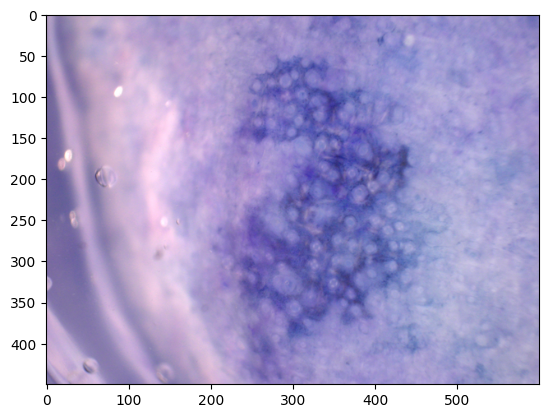

In [ ]:
import cv2
import os
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa

csv = "../csv/minority_train.csv"
df = pd.read_csv(csv)
img = df['image_pth'][120]
image = cv2.imread(img)
# image = Image.open(img)

plt.imshow(image)

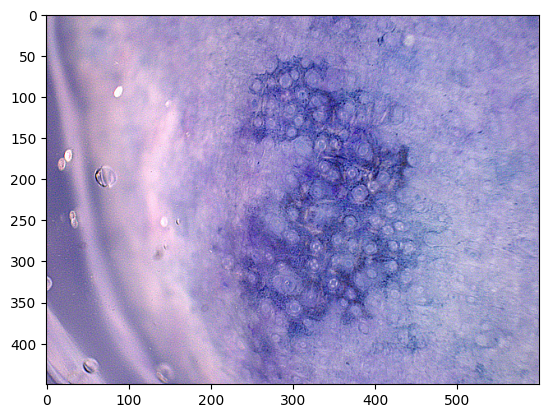

In [ ]:
# aug = iaa.Multiply(0.5)(image=image)
aug = iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5))(image=image)
plt.imshow(aug)



## Boosting


In [22]:
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from imgaug import augmenters as iaa
from sklearn.ensemble import IsolationForest
import xgboost as xgb
import pandas as pd
import imgaug as ia
import cv2
import matplotlib.pyplot as plt
import itertools
from tabulate import tabulate
import warnings
warnings.filterwarnings("ignore")

In [23]:
def plot_confusion_matrix(cm, class_names):
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, fontsize=8, horizontalalignment='right')
    plt.yticks(tick_marks, class_names, fontsize=8)
    threshold = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color, fontsize=7)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # return figure

In [24]:
# Load the dataset from the CSV file
data = pd.read_csv("../csv/minority_train.csv")

# Initialize variables to store sampled data as lists
sampled_image_paths = []
sampled_class_labels = []

# Specify the number of samples per class and the total number of samples
samples_per_class = 92  # Adjust as needed

# Iterate through unique classes
unique_classes = data["dx"].unique()
for class_label in unique_classes:
    # Select samples for the current class
    class_data = data[data["dx"] == class_label].head(samples_per_class)
    
    # Append the sampled image paths and class labels to the result lists
    sampled_image_paths.extend(class_data["image_pth"].tolist())
    sampled_class_labels.extend(class_data["dx"].tolist())


# Initialize an empty list to store images
images = []
for image_path in sampled_image_paths:
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    images.append(image)

X = np.array(images)  # Convert to numpy array
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(sampled_class_labels)
X = X.reshape(X.shape[0], -1)

print('splitting data')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = (X_train * 255).astype(np.uint8)
X_test = (X_test * 255).astype(np.uint8)


splitting data


In [25]:
# base_classifier = DecisionTreeClassifier(max_depth=3)
base_classifier = None

In [26]:
adaboost_classifier = AdaBoostClassifier(base_classifier, n_estimators=50, random_state=42)


In [27]:
adaboost_classifier.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3),
                   random_state=42)

In [56]:
print(f'Estimator Weight: {adaboost_classifier.estimator_weights_}')
print(f'Estimator: {adaboost_classifier.estimator_}')
print(f'Feature Importances: {adaboost_classifier.feature_importances_}')
print(f'Classes: {adaboost_classifier.n_classes_}')
print(f'Estimators Errors: {adaboost_classifier.estimator_errors_}')


Estimator Weight: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
Estimator: DecisionTreeClassifier(max_depth=3)
Feature Importances: [0. 0. 0. ... 0. 0. 0.]
Classes: 6
Estimators Errors: [0.53968254 0.47985017 0.4985376  0.5186681  0.46877436 0.40906732
 0.4086396  0.4089385  0.44078852 0.39947965 0.3687696  0.4159501
 0.39889946 0.39860033 0.35408738 0.36016449 0.34488523 0.37037855
 0.36096552 0.35561802 0.38001391 0.39451659 0.37542322 0.37390285
 0.40834696 0.37747462 0.3541136  0.34526693 0.35708015 0.3756119
 0.39506955 0.3506481  0.3456862  0.23999442 0.2195965  0.38179608
 0.33813339 0.38823171 0.36238459 0.3609701  0.37603599 0.33772887
 0.374761   0.34470667 0.39149413 0.36709553 0.36232991 0.34499262
 0.335031   0.39815545]


In [54]:
f = adaboost_classifier.feature_importances_


(270000,)

## Load Classifier

In [ ]:
import pickle
import os
clf = sorted(os.listdir('./classifier/'))
clfi = 9
with open(f'./classifier/{clf[clfi]}','rb') as f:
                    print(f'Loading {clf[clfi]} classifier...')
                    adaboost_classifier = pickle.load(f)
                    print(f'Estimator Weight: {adaboost_classifier.estimator_weights_}')

Loading model_7.pkl classifier...
Estimator Weight: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]


270000

### Get Prediction results

In [154]:
y_pred = adaboost_classifier.predict(X_test)
classification_rep = classification_report(y_test, y_pred, target_names=[i for i in range(0,len(np.unique(y_train)))], output_dict=True)
proba = adaboost_classifier.predict_proba(X_test)

In [155]:
print(f'True Labels:{y_test}, Predicted Labels:{y_pred}')
print(f'Class-Based Probabilities: \n {proba}')

True Labels:[3 1 2 1 5 4 3 3 1 4 5 1 1 5 4 1 3 1 4 5 5 2 2 2 1 1 0 1 3 2 3 1 5 0 1 2 0
 0 1 1 4 3 5 5 5 0 2 4 3 4 2 4 2 4 1 3 3 4 1 1 3 3 4 4 4 3 4 1 3 4 2 4 4 1
 3 3 2 0 0 2 2 4 1 2 3 1 3 1 3 2 5 3 3 1 5 5 1 1 4 1 0 0 2 1 2 0 3 5 2 0 1], Predicted Labels:[2 1 3 0 0 4 1 0 0 5 5 1 0 4 4 3 0 2 5 3 2 2 2 2 0 1 0 0 0 2 3 5 2 1 2 2 0
 2 2 2 0 0 4 2 2 0 4 2 3 4 2 2 3 4 0 0 2 4 0 0 0 3 5 4 5 1 3 0 0 4 2 0 4 2
 2 2 2 2 3 2 4 1 3 3 0 2 2 2 1 2 5 2 0 2 0 1 2 3 2 0 3 0 2 3 3 0 0 5 3 3 1]
Class-Based Probabilities: 
 [[1.83177770e-01 3.80728734e-02 4.22935770e-01 3.47886423e-02
  3.20973795e-02 2.88927565e-01]
 [2.74478455e-01 2.86951331e-01 1.31207657e-02 2.02046057e-01
  4.37981398e-03 2.19023578e-01]
 [2.66507596e-01 6.23036299e-02 2.38996921e-01 2.67987378e-01
  9.24549951e-03 1.54958975e-01]
 [2.59848529e-01 1.45068073e-01 2.50750011e-01 2.24859234e-01
  6.94747216e-03 1.12526680e-01]
 [2.28608233e-01 1.54898794e-01 2.13535110e-01 2.27651390e-01
  5.94825282e-03 1.69358221e-01]
 [1.56815375e-

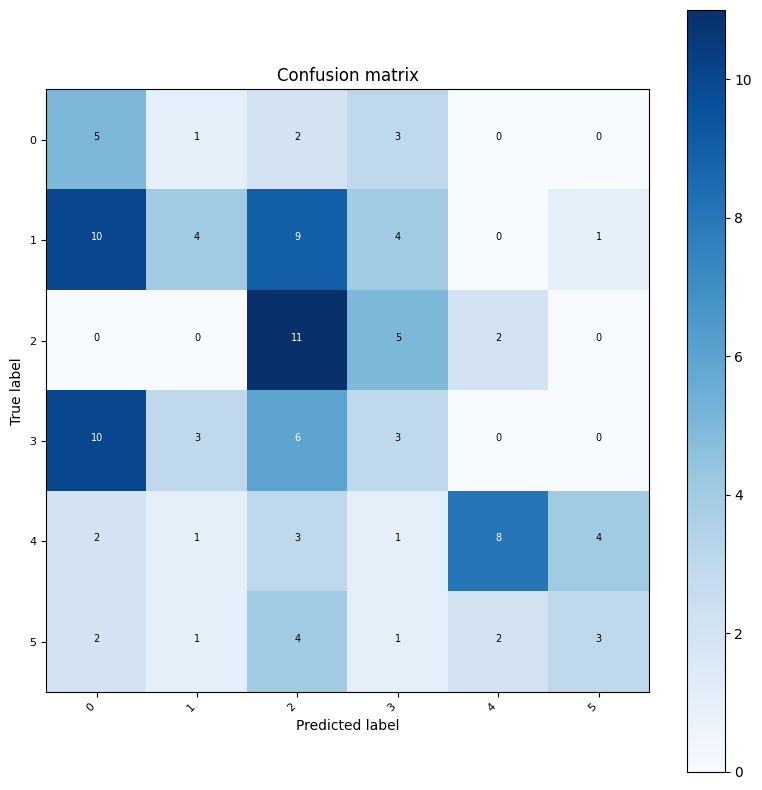

In [156]:

cf = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cf, [i for i in range(0,len(np.unique(y_train)))])

In [146]:
classification_rep

{0: {'precision': 0.1724137931034483,
  'recall': 0.45454545454545453,
  'f1-score': 0.25000000000000006,
  'support': 11.0},
 1: {'precision': 0.4,
  'recall': 0.14285714285714285,
  'f1-score': 0.21052631578947364,
  'support': 28.0},
 2: {'precision': 0.3142857142857143,
  'recall': 0.6111111111111112,
  'f1-score': 0.41509433962264153,
  'support': 18.0},
 3: {'precision': 0.17647058823529413,
  'recall': 0.13636363636363635,
  'f1-score': 0.15384615384615383,
  'support': 22.0},
 4: {'precision': 0.6666666666666666,
  'recall': 0.42105263157894735,
  'f1-score': 0.5161290322580646,
  'support': 19.0},
 5: {'precision': 0.375,
  'recall': 0.23076923076923078,
  'f1-score': 0.2857142857142857,
  'support': 13.0},
 'accuracy': 0.3063063063063063,
 'macro avg': {'precision': 0.35080612704852054,
  'recall': 0.3327832012042538,
  'f1-score': 0.30521835453843654,
  'support': 111.0},
 'weighted avg': {'precision': 0.3619613890912065,
  'recall': 0.3063063063063063,
  'f1-score': 0.29749

In [135]:
import time
start = time.time()

In [136]:
end = time.time()
diff = end - start
time.strftime("%Y-%m-%d %H:%M:%S", diff)

TypeError: Tuple or struct_time argument required

In [152]:
import pickle
with open(f'./classifier/model_01.pkl','rb') as f:
    adaboost_classifier = pickle.load(f)
    

In [151]:
with open(f'./classifier/model_01.pkl','wb') as f:
                print('Saving model...')
                pickle.dump(adaboost_classifier,f)
                

Saving model...


In [159]:
sorted(os.listdir('./classifier/'))

['model_0.pkl', 'model_1.pkl']

In [ ]:
def sign(x):
    return abs(x)/x if x!=0 else 1

def I(flag):
    return 1 if flag else 0


class AdaBoost:

    def __init__(self,n_estimators=50):
        self.n_estimators = n_estimators
        self.models = [None]*n_estimators

    def fit(self,X,y):

        X = np.float64(X)
        N = len(y)
        w = np.array([1/N for i in range(N)])

        for m in range(self.n_estimators):

            Gm = DecisionTreeClassifier(max_depth=1)\
                        .fit(X,y,sample_weight=w).predict

            errM = sum([w[i]*I(y[i]!=Gm(X[i].reshape(1,-1))) \
                        for i in range(N)])/sum(w)

            '''Confidence Value'''
            #BetaM = (1/2)*(np.log((1-errM)/errM))
            BetaM = np.log((1-errM)/errM)

            w = [w[i]*np.exp(BetaM*I(y[i]!=Gm(X[i].reshape(1,-1))))\
                     for i in range(N)] 


            self.models[m] = (BetaM,Gm)

    def predict(self,X):

        y = 0
        for m in range(self.n_estimators):
            BetaM,Gm = self.models[m]
            y += BetaM*Gm(X)
        signA = np.vectorize(sign)
        y = np.where(signA(y)==-1,-1,1)
        return y